In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

### Loading FBI NIBRS data 

#### The clean_nibrs_df function in this notebook should be able to do the preliminary data cleaning on all of the Federal NIBRS datasets found here [https://ucr.fbi.gov/nibrs/2018/tables/data-tables#federal-table](https://ucr.fbi.gov/nibrs/2018/tables/data-tables#federal-table). Simply change the year in the URL to get the corresponding table. 

In [2]:
# Load 2019 FBI NIBRS data

df_nibrs_19 = pd.read_excel('data/nibrs/United_States_Offense_Type_by_Agency_2019.xls', skiprows=[0,1,2])

df_nibrs_19.head()

,State,Agency Type,Agency Name,Population1,Total\nOffenses,Crimes\nAgainst\nPersons,Crimes\nAgainst\nProperty,Crimes\nAgainst\nSociety,Crimes Against Persons,Unnamed: 9,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Assault\nOffenses,Aggravated\nAssault,...,Betting/\nWagering,Operating/\nPromoting/\nAssisting\nGambling,Gambling\nEquipment\nViolations,Sports\nTampering,Por-\nnography/\nObscene\nMaterial,Pros-\ntitution\nOffenses,Pros-\ntitution,Assisting or\nPromoting\nProstitution,Purchasing\nProstitution,Weapon\nLaw\nViolations
1,ALABAMA,Cities,Hoover,85670.0,4293.0,840.0,2801.0,652.0,811,68,...,0,0,0,0,2,1,1,0,0,67
2,ARIZONA,Cities,Apache Junction2,42531.0,NaN,430.0,NaN,487.0,383,71,...,0,0,0,0,6,0,0,0,0,36
3,NaN,NaN,Coolidge,13138.0,1155.0,230.0,684.0,241.0,214,61,...,0,0,0,0,1,0,0,0,0,18
4,NaN,NaN,Eagar,4897.0,102.0,36.0,29.0,37.0,21,7,...,0,0,0,0,0,0,0,0,0,1


In [3]:
def clean_nibrs_df(df, year):

    # Get missing column names
    names = df.iloc[0].tolist()
    missing_names = names[8:]
    # missing_names = [name.replace('\n', ' ').replace(' ', '_').replace('/_', '/').replace('-_', '').replace('__', '_') for name in missing_names]

    #Get column names and replace UnNamed columns with the corresponding name
    column_names = df.columns.to_list()
    column_names = column_names[:8]
    for name in missing_names:
        column_names.append(name)

    #Clean the column names up
    column_names = [name.replace('\n', ' ').replace(' ', '_').replace('/_', '/').replace('-_', '').replace('__', '_') for name in column_names]
    df.columns = column_names
    df = df.drop(df.index[0])
    
    # Replace NaN values in 'State' with the first non-NaN value using ffill
    df['State'] = df['State'].fillna(method='ffill')
    
    # Make sure just the first letter is capitalized
    df['State'] = df['State'].str.capitalize()

    # Replace NaN values in 'Agency_Type' with the first non-NaN value using ffill
    df['Agency_Type'] = df['Agency_Type'].fillna(method='ffill')
    
    #filter to the city level
    df = df[df["Agency_Type"]=="Cities"]
    
    df["Year"] = year
    
    df.drop(['Agency_Type'], axis=1, inplace=True)
    
    df.rename(columns = {"Agency_Name":"City"}, inplace=True)
    
    df["State_City"] = df["State"] + ", " + df["City"]
    
    df.drop(["State", "City"], axis=1, inplace=True)
    
    df = df.groupby(["State_City"]).mean().reset_index()
    
    def calc_pct_tot(df, col_name):
        df[col_name + "_pct"] = df[col_name]/df["Population1"]
        return df

    df = calc_pct_tot(df, "Total_Offenses")
    df = calc_pct_tot(df, "Crimes_Against_Persons")
    df = calc_pct_tot(df, "Crimes_Against_Property")
    df = calc_pct_tot(df, "Crimes_Against_Society")
    
    df = df[["State_City","Population1", "Total_Offenses_pct",
             "Crimes_Against_Persons_pct", "Crimes_Against_Property_pct", 
             "Crimes_Against_Society_pct", "Year"]]
    
    df = df.dropna(axis = 0)
    
    return df

In [4]:
cleaned_df_nibrs_19 = clean_nibrs_df(df_nibrs_19, 2019)

cleaned_df_nibrs_19.head()

,State_City,Population1,Total_Offenses_pct,Crimes_Against_Persons_pct,Crimes_Against_Property_pct,Crimes_Against_Society_pct,Year
0,"Alabama, Hoover",85670.0,0.050111,0.009805,0.032695,0.007611,2019.0
2,"Arizona, Coolidge",13138.0,0.087913,0.017506,0.052063,0.018344,2019.0
3,"Arizona, Eagar",4897.0,0.020829,0.007351,0.005922,0.007556,2019.0
4,"Arizona, Gilbert",253619.0,0.041752,0.007271,0.024225,0.010256,2019.0
5,"Arizona, Huachuca City",1723.0,0.042368,0.015090,0.023796,0.003482,2019.0


In [5]:
print(cleaned_df_nibrs_19.shape)

(4143, 7)


### Loading CDC Drug/Alcohol Related Deaths

In [6]:
df_cdc = pd.read_csv('data/cdc/Underlying Cause of Death, 2018-2021, Single Race (version 1).csv')

In [7]:
df_cdc.drop('Notes', axis=1, inplace=True)
df_cdc.head()

,County,County Code,Drug/Alcohol Induced,Drug/Alcohol Induced Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,Population,Crude Rate,pct_tot,Years
0,"Autauga County, AL",1001,Drug-induced causes,D,Drug poisonings (overdose) Unintentional (X40-...,D1,20,226710,8.8,0.000088,2018-2021
1,"Autauga County, AL",1001,Alcohol-induced causes,A,All other alcohol-induced causes,A9,16,226710,Unreliable,0.000071,2018-2021
2,"Autauga County, AL",1001,All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,2398,226710,1057.7,0.010577,2018-2021
3,"Baldwin County, AL",1003,Drug-induced causes,D,Drug poisonings (overdose) Unintentional (X40-...,D1,185,909837,20.3,0.000203,2018-2021
4,"Baldwin County, AL",1003,Drug-induced causes,D,Drug poisonings (overdose) Suicide (X60-X64),D2,17,909837,Unreliable,0.000019,2018-2021


In [8]:
df_cdc.shape

(8244, 11)

In [9]:
df_cdc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8244 entries, 0 to 8243
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   County                           8244 non-null   object 
 1   County Code                      8244 non-null   int64  
 2   Drug/Alcohol Induced             8244 non-null   object 
 3   Drug/Alcohol Induced Code        8244 non-null   object 
 4   Drug/Alcohol Induced Cause       8244 non-null   object 
 5   Drug/Alcohol Induced Cause Code  8244 non-null   object 
 6   Deaths                           8244 non-null   int64  
 7   Population                       8244 non-null   int64  
 8   Crude Rate                       8244 non-null   object 
 9   pct_tot                          8244 non-null   float64
 10  Years                            8244 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 708.6+ KB


In [10]:
total = df_cdc.groupby(['County Code']).sum().reset_index()
total

,County Code,County,Drug/Alcohol Induced,Drug/Alcohol Induced Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,Population,Crude Rate,pct_tot,Years
0,1001,"Autauga County, ALAutauga County, ALAutauga Co...",Drug-induced causesAlcohol-induced causesAll o...,DAO,Drug poisonings (overdose) Unintentional (X40-...,D1A9O9,2434,680130,8.8Unreliable1057.7,0.010736,2018-20212018-20212018-2021
1,1003,"Baldwin County, ALBaldwin County, ALBaldwin Co...",Drug-induced causesDrug-induced causesAlcohol-...,DDAO,Drug poisonings (overdose) Unintentional (X40-...,D1D2A9O9,10408,3639348,20.3Unreliable15.11106.7,0.011439,2018-20212018-20212018-20212018-2021
2,1005,"Barbour County, AL",All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,1385,99120,1397.3,0.013973,2018-2021
3,1007,"Bibb County, ALBibb County, AL",Drug-induced causesAll other non-drug and non-...,DO,Drug poisonings (overdose) Unintentional (X40-...,D1O9,1163,178814,Unreliable1280.7,0.013008,2018-20212018-2021
4,1009,"Blount County, ALBlount County, ALBlount Count...",Drug-induced causesAlcohol-induced causesAll o...,DAO,Drug poisonings (overdose) Unintentional (X40-...,D1A9O9,3081,697758,16.810.31297.6,0.013247,2018-20212018-20212018-2021
...,...,...,...,...,...,...,...,...,...,...,...
3134,56037,"Sweetwater County, WYSweetwater County, WYSwee...",Drug-induced causesAlcohol-induced causesAll o...,DAO,Drug poisonings (overdose) Unintentional (X40-...,D1A9O9,1463,509043,18.326.5817.4,0.008622,2018-20212018-20212018-2021
3135,56039,"Teton County, WY",All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,377,93617,402.7,0.004027,2018-2021
3136,56041,"Uinta County, WYUinta County, WYUinta County, WY",Drug-induced causesAlcohol-induced causesAll o...,DAO,Drug poisonings (overdose) Unintentional (X40-...,D1A9O9,673,244125,UnreliableUnreliable787.7,0.008270,2018-20212018-20212018-2021
3137,56043,"Washakie County, WY",All other non-drug and non-alcohol causes,O,All other non-drug and non-alcohol causes,O9,383,31155,1229.3,0.012293,2018-2021


In [11]:
cdc_main = total[["County Code", "Deaths", "Population", "pct_tot"]]
cdc_main["Years"] = "2018-2021"
cdc_main

<ipython-input-11-ad1d09aecd72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_main["Years"] = "2018-2021"


,County Code,Deaths,Population,pct_tot,Years
0,1001,2434,680130,0.010736,2018-2021
1,1003,10408,3639348,0.011439,2018-2021
2,1005,1385,99120,0.013973,2018-2021
3,1007,1163,178814,0.013008,2018-2021
4,1009,3081,697758,0.013247,2018-2021
...,...,...,...,...,...
3134,56037,1463,509043,0.008622,2018-2021
3135,56039,377,93617,0.004027,2018-2021
3136,56041,673,244125,0.008270,2018-2021
3137,56043,383,31155,0.012293,2018-2021


In [12]:
cdc_main['pct_tot'] = cdc_main['Deaths']/cdc_main['Population']
cdc_main

<ipython-input-12-2ec0190d8883>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_main['pct_tot'] = cdc_main['Deaths']/cdc_main['Population']


,County Code,Deaths,Population,pct_tot,Years
0,1001,2434,680130,0.003579,2018-2021
1,1003,10408,3639348,0.002860,2018-2021
2,1005,1385,99120,0.013973,2018-2021
3,1007,1163,178814,0.006504,2018-2021
4,1009,3081,697758,0.004416,2018-2021
...,...,...,...,...,...
3134,56037,1463,509043,0.002874,2018-2021
3135,56039,377,93617,0.004027,2018-2021
3136,56041,673,244125,0.002757,2018-2021
3137,56043,383,31155,0.012293,2018-2021


In [13]:
col_names = ["County", "DrugOrAlc_Deaths", "Population", "DrugOrAlc_Deaths_pct", "Years"]
cdc_main.columns = col_names
cdc_main.head()

,County,DrugOrAlc_Deaths,Population,DrugOrAlc_Deaths_pct,Years
0,1001,2434,680130,0.003579,2018-2021
1,1003,10408,3639348,0.002860,2018-2021
2,1005,1385,99120,0.013973,2018-2021
3,1007,1163,178814,0.006504,2018-2021
4,1009,3081,697758,0.004416,2018-2021


In [14]:
cdc_main.shape

(3139, 5)

In [15]:
# df_select_counties.shape
# print(df_select_counties.columns)

In [16]:
# df_select_counties.rename(columns={"Common County Name": "County"}, inplace=True)

# Combining datasets to create our master dataset.

This notebook can be used to explore different options for combining our data. 

### Loading and preprocessing the HPSA dataset.

In [17]:
import time, os, math, numpy as np, pandas as pd, sklearn as sk, matplotlib as plt
# import sqlite3
from pandasql import sqldf
import seaborn as sns
pysqldf = lambda q: sqldf(q, globals())

In [18]:
# Load dataset for all Primary Care HPSA destinations with one record per facility
df_hpsa_pc = pd.read_csv("data/hpsa/BCD_HPSA_FCT_DET_PC.csv")

In [19]:
# q = """SELECT * 
#        FROM df_hpsa_pc
#        LIMIT 10;"""

# pysqldf(q)

In [20]:
print("Unique HPSA IDs: " + str(df_hpsa_pc['HPSA ID'].nunique()))
print("Unique Zip Codes: " + str(df_hpsa_pc["Common Postal Code"].nunique()))
print("Unique Cities: " + str(df_hpsa_pc["HPSA City"].nunique()))
print("Unique Counties " + str(df_hpsa_pc["Common County Name"].nunique()))

Unique HPSA IDs: 15939
Unique Zip Codes: 4557
Unique Cities: 3319
Unique Counties 3210


In [21]:
df_hpsa_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66858 entries, 0 to 66857
Data columns (total 66 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   HPSA Name                                                                 66858 non-null  object 
 1   HPSA ID                                                                   66858 non-null  object 
 2   Designation Type                                                          66858 non-null  object 
 3   HPSA Discipline Class                                                     66858 non-null  object 
 4   HPSA Score                                                                66858 non-null  int64  
 5   PC MCTA Score                                                             21358 non-null  float64
 6   Primary State Abbreviation                                    

In [22]:
df_hpsa_pc.nunique().reset_index().sort_values(by=0, ascending=False).head(20)

,index,0
36,HPSA Component Name,38080
11,HPSA Geography Identification Number,36085
1,HPSA ID,15939
0,HPSA Name,14177
15,HPSA Designation Population,11432
37,HPSA Component Source Identification Number,7269
43,HPSA Estimated Underserved Population,6617
21,Latitude,6421
20,Longitude,6420
34,HPSA Address,6147


In [23]:
df_hpsa_pc[["HPSA Component Name", "HPSA Geography Identification Number", "Common State County FIPS Code"]]

,HPSA Component Name,HPSA Geography Identification Number,Common State County FIPS Code
0,"Census Tract 48, Lucas County, Ohio",39095004800,39095
1,"Census Tract 46, Lucas County, Ohio",39095004600,39095
2,"Census Tract 47.01, Lucas County, Ohio",39095004701,39095
3,Noble Correctional Institution,POINT,39121
4,EDGERTON FAMILY HEALTH CENTER,POINT,39171
...,...,...,...
66853,Lipscomb,48295,48295
66854,SEMINOLE FAMILY MEDICAL CLINIC,POINT,48165
66855,Schleicher,48413,48413
66856,Baylor,48023,48023


In [24]:
df_hpsa_pc["HPSA Geography Identification Number"].value_counts()

HPSA Geography Identification Number
POINT          7269
47011             9
36005003500       7
36005008300       7
24510260303       7
               ... 
48215022600       1
48215021600       1
48215021401       1
48215021903       1
48295             1
Name: count, Length: 36085, dtype: int64

In [25]:
df_hpsa_pc['Designation Type'].value_counts()

Designation Type
HPSA Population                                                                31873
Geographic HPSA                                                                23350
High Needs Geographic HPSA                                                      4366
Rural Health Clinic                                                             2970
Federally Qualified Health Center                                               1579
Indian Health Service, Tribal Health, and Urban Indian Health Organizations     1181
Correctional Facility                                                            991
Federally Qualified Health Center Look A Like                                    296
Other Facility                                                                   252
Name: count, dtype: int64

In [26]:
df_hpsa_pc = df_hpsa_pc[(df_hpsa_pc['Designation Type']=="HPSA Population") | 
                        (df_hpsa_pc["Designation Type"]=="Geographic HPSA") |
                        (df_hpsa_pc["Designation Type"]=="High Needs Geographic HPSA")
                       ]

len(df_hpsa_pc)

59589

In [27]:
df_hpsa_pc.rename(columns={"Common State County FIPS Code":"CountyFIPS", "HPSA Geography Identification Number":"LocationID"}, inplace=True)

Note: We might want to try generating multiple years worth of data to expand the number of rows in the city dataset. 

In [28]:
# print(len(combined_df_cities[combined_df_cities['PC_HPSA_Score']==0]))
# len(combined_df_counties[combined_df_counties['PC_HPSA_Score']==0])

## Adding the Places Project data, which contains health data on cities including census tract levels. 

In [29]:
df_places = pd.read_csv('data/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2023_release_20240418.csv')

In [30]:
df_places.head()

,Year,StateAbbr,StateDesc,CountyName,CountyFIPS,LocationName,DataSource,Category,Measure,Data_Value_Unit,...,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,2021,AL,Alabama,Baldwin,1003,1003011300,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,...,NaN,29.8,40.9,4487,POINT (-87.87730464 30.43411562),1003011300,HLTHOUT,OBESITY,CrdPrv,Obesity
1,2021,AL,Alabama,Chambers,1017,1017954000,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,...,NaN,38.0,54.3,6669,POINT (-85.46010298 32.86128629),1017954000,HLTHOUT,OBESITY,CrdPrv,Obesity
2,2021,AL,Alabama,Cleburne,1029,1029959600,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,...,NaN,31.0,47.8,4202,POINT (-85.56228862 33.69258271),1029959600,HLTHOUT,OBESITY,CrdPrv,Obesity
3,2021,AL,Alabama,Covington,1039,1039962000,BRFSS,Health Outcomes,Stroke among adults aged >=18 years,%,...,NaN,3.8,4.6,3917,POINT (-86.4651625 31.34674334),1039962000,HLTHOUT,STROKE,CrdPrv,Stroke
4,2021,AL,Alabama,Fayette,1057,1057020400,BRFSS,Health Outcomes,Obesity among adults aged >=18 years,%,...,NaN,28.4,44.1,3550,POINT (-87.60702531 33.64745531),1057020400,HLTHOUT,OBESITY,CrdPrv,Obesity


In [31]:
df_places["Year"].value_counts()

Year
2021    1976988
2020     578125
Name: count, dtype: int64

In [32]:
df_places[["CountyName","CountyFIPS","LocationID"]].dtypes

CountyName    object
CountyFIPS     int64
LocationID     int64
dtype: object

In [33]:
df_hpsa_pc["CountyFIPS"] = pd.to_numeric(df_hpsa_pc["CountyFIPS"], errors='coerce')
df_hpsa_pc["LocationID"] = pd.to_numeric(df_hpsa_pc["LocationID"], errors='coerce')

In [34]:
df_hpsa_pc[["HPSA Status", "CountyFIPS", "LocationID"]].dtypes

HPSA Status    object
CountyFIPS      int64
LocationID      int64
dtype: object

In [35]:
df_hpsa_pc[["HPSA Status", "CountyFIPS", "LocationID"]].head()

,HPSA Status,CountyFIPS,LocationID
0,Designated,39095,39095004800
1,Designated,39095,39095004600
2,Designated,39095,39095004701
5,Designated,39035,39035151800
6,Designated,39035,39035150100


In [36]:
df = df_places.merge(df_hpsa_pc, how='left', on="LocationID")

In [37]:
# df.to_csv('data/hpsa_cdcplaces')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3126640 entries, 0 to 3126639
Data columns (total 88 columns):
 #   Column                                                                    Dtype  
---  ------                                                                    -----  
 0   Year                                                                      int64  
 1   StateAbbr                                                                 object 
 2   StateDesc                                                                 object 
 3   CountyName                                                                object 
 4   CountyFIPS_x                                                              int64  
 5   LocationName                                                              int64  
 6   DataSource                                                                object 
 7   Category                                                                  object 
 8   Measure     

In [40]:
# df[(df["HPSA Score"].isna()==True) &

In [41]:
df_combined = df[df["HPSA Score"].isna()==False]

In [42]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1304812 entries, 0 to 3126636
Data columns (total 88 columns):
 #   Column                                                                    Non-Null Count    Dtype  
---  ------                                                                    --------------    -----  
 0   Year                                                                      1304812 non-null  int64  
 1   StateAbbr                                                                 1304812 non-null  object 
 2   StateDesc                                                                 1304812 non-null  object 
 3   CountyName                                                                1304812 non-null  object 
 4   CountyFIPS_x                                                              1304812 non-null  int64  
 5   LocationName                                                              1304812 non-null  int64  
 6   DataSource                                     

In [43]:
df_combined.dropna(axis=1, inplace=True)

<ipython-input-43-d79af65d4157>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined.dropna(axis=1, inplace=True)


In [44]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1304812 entries, 0 to 3126636
Data columns (total 63 columns):
 #   Column                                                                    Non-Null Count    Dtype  
---  ------                                                                    --------------    -----  
 0   Year                                                                      1304812 non-null  int64  
 1   StateAbbr                                                                 1304812 non-null  object 
 2   StateDesc                                                                 1304812 non-null  object 
 3   CountyName                                                                1304812 non-null  object 
 4   CountyFIPS_x                                                              1304812 non-null  int64  
 5   LocationName                                                              1304812 non-null  int64  
 6   DataSource                                     

In [45]:
df_combined.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS_x',
       'LocationName', 'DataSource', 'Category', 'Measure', 'Data_Value_Unit',
       'Data_Value_Type', 'Data_Value', 'Low_Confidence_Limit',
       'High_Confidence_Limit', 'TotalPopulation', 'Geolocation', 'LocationID',
       'CategoryID', 'MeasureId', 'DataValueTypeID', 'Short_Question_Text',
       'HPSA Name', 'HPSA ID', 'Designation Type', 'HPSA Discipline Class',
       'HPSA Score', 'Primary State Abbreviation', 'HPSA Status',
       'HPSA Designation Date', 'HPSA Designation Last Update Date',
       'Metropolitan Indicator', 'HPSA Degree of Shortage',
       'HPSA Population Type', 'Break in Designation', 'Common County Name',
       'Common Region Name', 'Common State Abbreviation', 'CountyFIPS_y',
       'Common State FIPS Code', 'Common State Name', 'County Equivalent Name',
       'County or County Equivalent Federal Information Processing Standard Code',
       'Discipline Class Number', 'HPSA Compo

In [46]:
df_filtered = df_combined[['Year', 'StateDesc', 'CountyName', 'CountyFIPS_x',
       'LocationID', 'Category', 'MeasureId', 'Data_Value', 'Low_Confidence_Limit',
       'High_Confidence_Limit', 'TotalPopulation', 'Geolocation', 'Short_Question_Text',
       'Designation Type', 'HPSA Score', 'HPSA Status',
       'HPSA Designation Date', 'HPSA Designation Last Update Date',
       'Metropolitan Indicator', 'HPSA Degree of Shortage',
       'HPSA Population Type', 'Common County Name',
       'HPSA Designation Population Type Description',
       'HPSA Metropolitan Indicator Code', 'HPSA Provider Ratio Goal',
       'U.S. - Mexico Border 100 Kilometer Indicator']]

df_filtered['HPSA Designation Year'] = df_filtered['HPSA Designation Date'].str[-4:].astype(int)
df_filtered['HPSA Designation Last Update Year'] = df_filtered['HPSA Designation Last Update Date'].str[-4:].astype(int)
df_filtered['U.S. - Mexico Border 100 Kilometer Indicator'] = df_filtered['U.S. - Mexico Border 100 Kilometer Indicator'].replace({'N': 0, 'U': 0, 'Y': 1})

df_filtered.drop(['HPSA Designation Date', 'HPSA Designation Last Update Date'], axis=1, inplace=True)

<ipython-input-46-2046dbbc30f5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['HPSA Designation Year'] = df_filtered['HPSA Designation Date'].str[-4:].astype(int)
<ipython-input-46-2046dbbc30f5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['HPSA Designation Last Update Year'] = df_filtered['HPSA Designation Last Update Date'].str[-4:].astype(int)
<ipython-input-46-2046dbbc30f5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [47]:
df_filtered.nunique()

Year                                                2
StateDesc                                          51
CountyName                                        474
CountyFIPS_x                                      567
LocationID                                      21431
Category                                            5
MeasureId                                          37
Data_Value                                        961
Low_Confidence_Limit                              951
High_Confidence_Limit                             968
TotalPopulation                                  6867
Geolocation                                     21431
Short_Question_Text                                37
Designation Type                                    3
HPSA Score                                         23
HPSA Status                                         3
Metropolitan Indicator                              4
HPSA Degree of Shortage                             1
HPSA Population Type        

In [48]:
df_filtered.head()

,Year,StateDesc,CountyName,CountyFIPS_x,LocationID,Category,MeasureId,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,...,Metropolitan Indicator,HPSA Degree of Shortage,HPSA Population Type,Common County Name,HPSA Designation Population Type Description,HPSA Metropolitan Indicator Code,HPSA Provider Ratio Goal,U.S. - Mexico Border 100 Kilometer Indicator,HPSA Designation Year,HPSA Designation Last Update Year
0,2021,Alabama,Baldwin,1003,1003011300,Health Outcomes,OBESITY,35.1,29.8,40.9,...,Unknown,Not applicable,Low Income Population HPSA,"Baldwin County, AL",Low Income Population HPSA,0,3000:1,0,1998,2024
1,2021,Alabama,Chambers,1017,1017954000,Health Outcomes,OBESITY,46.3,38.0,54.3,...,Unknown,Not applicable,Geographic Population,"Chambers County, AL",Geographic Population,0,3500:1,0,1978,2024
2,2021,Alabama,Chambers,1017,1017954000,Health Outcomes,OBESITY,46.3,38.0,54.3,...,Metropolitan,Not applicable,Geographic Population,"Chambers County, AL",Geographic Population,M,3500:1,0,1979,1985
7,2021,Alabama,Jefferson,1073,1073002000,Health Outcomes,STROKE,6.0,5.3,6.8,...,Unknown,Not applicable,Low Income Population HPSA,"Jefferson County, AL",Low Income Population HPSA,0,3000:1,0,2002,2024
8,2021,Alabama,Jefferson,1073,1073003600,Health Outcomes,STROKE,5.1,4.5,5.7,...,Unknown,Not applicable,Low Income Population HPSA,"Jefferson County, AL",Low Income Population HPSA,0,3000:1,0,2002,2024


In [49]:
# filter to the relevant years
df_filtered = df_filtered[df_filtered['HPSA Designation Last Update Year'] >= 2020]

In [50]:
df_filtered.shape

(645442, 26)

In [51]:
# df_filtered.to_csv('data/hpsa_cdcplaces_cleaned')

In [52]:
df_filtered.head()

,Year,StateDesc,CountyName,CountyFIPS_x,LocationID,Category,MeasureId,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,...,Metropolitan Indicator,HPSA Degree of Shortage,HPSA Population Type,Common County Name,HPSA Designation Population Type Description,HPSA Metropolitan Indicator Code,HPSA Provider Ratio Goal,U.S. - Mexico Border 100 Kilometer Indicator,HPSA Designation Year,HPSA Designation Last Update Year
0,2021,Alabama,Baldwin,1003,1003011300,Health Outcomes,OBESITY,35.1,29.8,40.9,...,Unknown,Not applicable,Low Income Population HPSA,"Baldwin County, AL",Low Income Population HPSA,0,3000:1,0,1998,2024
1,2021,Alabama,Chambers,1017,1017954000,Health Outcomes,OBESITY,46.3,38.0,54.3,...,Unknown,Not applicable,Geographic Population,"Chambers County, AL",Geographic Population,0,3500:1,0,1978,2024
7,2021,Alabama,Jefferson,1073,1073002000,Health Outcomes,STROKE,6.0,5.3,6.8,...,Unknown,Not applicable,Low Income Population HPSA,"Jefferson County, AL",Low Income Population HPSA,0,3000:1,0,2002,2024
8,2021,Alabama,Jefferson,1073,1073003600,Health Outcomes,STROKE,5.1,4.5,5.7,...,Unknown,Not applicable,Low Income Population HPSA,"Jefferson County, AL",Low Income Population HPSA,0,3000:1,0,2002,2024
9,2021,Alabama,Jefferson,1073,1073003802,Health Outcomes,STROKE,4.6,4.1,5.0,...,Unknown,Not applicable,Low Income Population HPSA,"Jefferson County, AL",Low Income Population HPSA,0,3000:1,0,2002,2024


In [53]:
df_healthout = df_filtered.groupby(["LocationID", "Category", "MeasureId"])[["Data_Value","HPSA Score",'TotalPopulation']].mean().reset_index()
df_healthout.head(20)

,LocationID,Category,MeasureId,Data_Value,HPSA Score,TotalPopulation
0,1001020100,Disability,COGNITION,14.6,16.0,1912.0
1,1001020100,Disability,DISABILITY,30.9,16.0,1912.0
2,1001020100,Disability,HEARING,6.3,16.0,1912.0
3,1001020100,Disability,INDEPLIVE,8.3,16.0,1912.0
4,1001020100,Disability,MOBILITY,15.5,16.0,1912.0
5,1001020100,Disability,SELFCARE,3.9,16.0,1912.0
6,1001020100,Disability,VISION,4.7,16.0,1912.0
7,1001020100,Health Outcomes,ARTHRITIS,30.1,16.0,1912.0
8,1001020100,Health Outcomes,BPHIGH,37.7,16.0,1912.0
9,1001020100,Health Outcomes,CANCER,6.6,16.0,1912.0


In [54]:
# Pivot table with desired format
pivoted_df = df_healthout.pivot_table(values='Data_Value', index='LocationID', columns='MeasureId')

# Convert pivot table to DataFrame (if desired)
pivoted_df = pivoted_df.reset_index()

pivoted_df

MeasureId,LocationID,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,CASTHMA,CERVICAL,CHD,...,MAMMOUSE,MHLTH,MOBILITY,OBESITY,PHLTH,SELFCARE,SLEEP,STROKE,TEETHLOST,VISION
0,1001020100,10.2,30.1,15.4,37.7,79.0,6.6,10.3,83.5,6.0,...,76.8,18.3,15.5,38.7,12.5,3.9,36.9,3.0,14.6,4.7
1,1001020200,13.7,28.8,13.9,42.2,78.8,5.3,11.3,84.6,5.4,...,81.0,19.4,17.8,45.0,13.2,5.0,43.4,3.6,19.4,6.5
2,1001020300,11.4,30.1,15.1,38.5,79.1,6.6,10.6,82.6,6.1,...,76.9,18.9,16.4,39.4,12.8,4.1,38.1,3.3,16.2,5.2
3,1001020400,7.9,32.0,15.0,38.3,81.7,8.4,9.3,85.9,6.5,...,75.5,15.2,14.2,34.8,10.9,3.0,33.4,3.1,10.9,3.6
4,1001020500,8.4,26.5,16.3,33.7,76.6,6.2,9.8,86.0,4.7,...,77.8,16.6,12.0,36.3,10.1,2.9,35.7,2.4,11.1,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14969,56025001401,13.5,23.2,20.0,27.1,70.8,5.8,10.1,80.3,4.7,...,64.0,17.0,11.4,33.9,11.7,3.2,35.2,2.5,16.5,4.0
14970,56033000500,8.4,24.7,16.5,30.5,76.5,8.0,9.1,83.3,5.7,...,73.0,13.3,11.5,30.7,10.3,2.9,30.1,2.8,12.5,3.4
14971,56041975200,10.9,22.0,17.1,27.8,71.8,6.4,9.4,82.2,4.9,...,65.4,14.9,10.6,32.5,10.3,2.9,34.3,2.5,13.4,3.5
14972,56041975300,14.9,22.2,16.0,29.0,70.9,5.6,10.2,79.5,5.2,...,66.2,17.2,12.8,36.1,12.1,4.0,36.0,2.7,17.3,5.1


In [55]:
df_final = pivoted_df.merge(df_filtered, how='left', on='LocationID')
df_final.head()

,LocationID,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,CASTHMA,CERVICAL,CHD,...,Metropolitan Indicator,HPSA Degree of Shortage,HPSA Population Type,Common County Name,HPSA Designation Population Type Description,HPSA Metropolitan Indicator Code,HPSA Provider Ratio Goal,U.S. - Mexico Border 100 Kilometer Indicator,HPSA Designation Year,HPSA Designation Last Update Year
0,1001020100,10.2,30.1,15.4,37.7,79.0,6.6,10.3,83.5,6.0,...,Unknown,Not applicable,Low Income Population HPSA,"Autauga County, AL",Low Income Population HPSA,0,3000:1,0,1985,2024
1,1001020100,10.2,30.1,15.4,37.7,79.0,6.6,10.3,83.5,6.0,...,Unknown,Not applicable,Low Income Population HPSA,"Autauga County, AL",Low Income Population HPSA,0,3000:1,0,1985,2024
2,1001020100,10.2,30.1,15.4,37.7,79.0,6.6,10.3,83.5,6.0,...,Unknown,Not applicable,Low Income Population HPSA,"Autauga County, AL",Low Income Population HPSA,0,3000:1,0,1985,2024
3,1001020100,10.2,30.1,15.4,37.7,79.0,6.6,10.3,83.5,6.0,...,Unknown,Not applicable,Low Income Population HPSA,"Autauga County, AL",Low Income Population HPSA,0,3000:1,0,1985,2024
4,1001020100,10.2,30.1,15.4,37.7,79.0,6.6,10.3,83.5,6.0,...,Unknown,Not applicable,Low Income Population HPSA,"Autauga County, AL",Low Income Population HPSA,0,3000:1,0,1985,2024


In [56]:
df_final.shape

(645442, 63)

In [57]:
df_final = df_final[['LocationID','ACCESS2', 'ARTHRITIS', 'BINGE', 'BPHIGH', 'BPMED', 'CANCER', 'CASTHMA',
                     'CERVICAL','CHD','CHECKUP','CHOLSCREEN','COGNITION','COLON_SCREEN','COPD','COREM',
                     'COREW','CSMOKING','DENTAL','DEPRESSION','DIABETES','DISABILITY','GHLTH','HEARING',
                     'HIGHCHOL','INDEPLIVE','KIDNEY','LPA','MAMMOUSE','MHLTH','MOBILITY','OBESITY','PHLTH',
                     'SELFCARE','SLEEP','STROKE','TEETHLOST','VISION','HPSA Status','Metropolitan Indicator', 
                     'HPSA Population Type', 'Common County Name','U.S. - Mexico Border 100 Kilometer Indicator', 
                     'HPSA Score']]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645442 entries, 0 to 645441
Data columns (total 44 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   LocationID                                    645442 non-null  int64  
 1   ACCESS2                                       627030 non-null  float64
 2   ARTHRITIS                                     627030 non-null  float64
 3   BINGE                                         627030 non-null  float64
 4   BPHIGH                                        627030 non-null  float64
 5   BPMED                                         627030 non-null  float64
 6   CANCER                                        627030 non-null  float64
 7   CASTHMA                                       627030 non-null  float64
 8   CERVICAL                                      645308 non-null  float64
 9   CHD                                           62

In [58]:
df_final.dropna(axis=0, inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625152 entries, 0 to 645441
Data columns (total 44 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   LocationID                                    625152 non-null  int64  
 1   ACCESS2                                       625152 non-null  float64
 2   ARTHRITIS                                     625152 non-null  float64
 3   BINGE                                         625152 non-null  float64
 4   BPHIGH                                        625152 non-null  float64
 5   BPMED                                         625152 non-null  float64
 6   CANCER                                        625152 non-null  float64
 7   CASTHMA                                       625152 non-null  float64
 8   CERVICAL                                      625152 non-null  float64
 9   CHD                                           625152 

In [61]:
df_final["LocationID"].value_counts()

LocationID
9003480600     148
9003480700     148
29189214500    111
24510070200    111
24510070400    111
              ... 
17031570100     37
17031570200     37
17031570300     37
17031570400     37
56041975400     37
Name: count, Length: 13049, dtype: int64

<AxesSubplot:>

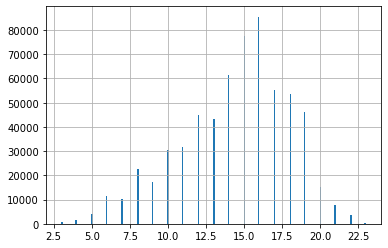

In [60]:
df_final["HPSA Score"].hist(bins='auto')

## ACS Median Income, Sex, Age, and Race Data



In [ ]:
df_acs = pd.read_csv('data/df_acs_combined.csv')

In [ ]:
df_acs.shape

In [ ]:
df_acs['LocationID'].nunique()

In [ ]:
df_acs.head(3)

In [ ]:
df.head()

In [ ]:
# df_hpsa_pc.head()

In [ ]:
# df_final2 = df_hpsa_pc.merge(df_acs_combined, how='inner', on='LocationID')
# df_final2.shape

In [ ]:
# df_final2["LocationID"] = pd.to_numeric(df_final2["LocationID"], errors='coerce')

In [ ]:
# df_final2["LocationID"]

In [ ]:
# df_final3 = df_final2.merge(df, how='inner', on='LocationID')
# df_final3.shape

# County Level

In [ ]:
df_acs_combined["CountyID"] = df_acs_combined["GeographyID_x"].astype(str).str[9:14].astype(int)

In [ ]:
df_acs_combined.head()

In [ ]:
numeric_columns = df_acs_combined.select_dtypes(include=[np.number])
numeric_columns.drop("LocationID", axis=1, inplace=True)

In [ ]:
df_acs_combined_county = numeric_columns.groupby("CountyID").mean().reset_index()

In [ ]:
df_acs_combined_county.head()

In [ ]:
df_filtered["LocationID"].value_counts()

In [ ]:
def create_county_id(location_id):
  """
  Extracts the first 4 or 5 digits from the location ID to create a CountyID.

  Args:
      location_id (int): The location ID.

  Returns:
      int: The CountyID (first 4 or 5 digits of location ID).
  """
  if len(str(location_id)) == 10:
    return location_id // 10000  # Integer division for extracting first 4 digits
  elif len(str(location_id)) == 11:
    return location_id // 1000  # Integer division for extracting first 5 digits
  else:
    return None  # Handle cases where location ID length is not 10 or 11

# Apply the function to create the CountyID column
df_filtered['CountyID'] = df_filtered['LocationID'].apply(create_county_id)

df_filtered.head()

In [ ]:
df_final["CountyID"] = df_final["LocationID"].astype(str).str[:4].astype(int)

In [ ]:
numeric_columns = df_final.select_dtypes(include=[np.number])
numeric_columns.drop("LocationID", axis=1, inplace=True)

In [ ]:
HPSA_Places_county = numeric_columns.groupby("CountyID").mean().reset_index()

In [ ]:
HPSA_Places_county.head()

In [ ]:
df_hpsa_final = HPSA_Places_county.merge(df_acs_combined_county, how='inner', on='CountyID')
df_hpsa_final